In [30]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

# Minimalistic exploration for handling *Binomial* models


In [22]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import itertools as it
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.4.1


## Read the data stored

In [25]:
datatrain = pd.read_csv("/outputs/sample_data.csv")
datatrain.columns

Index([u'Unnamed: 0', u'id', u'Y', u'7717', u'5386', u'6701', u'4691', u'3065',
       u'2393', u'7708', u'6685', u'8798', u'Elevation_mean',
       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
       u'WindSpeed_mean', u'Longitude', u'Latitude'],
      dtype='object')

In [26]:
datapred = pd.read_csv('/outputs/sample_predictors.csv')
datapred.columns

Index([u'Unnamed: 0', u'SolarRadiation', u'Elevation', u'MinTemperature',
       u'MaxTemperature', u'WindSpeed', u'MeanTemperature', u'Vapor',
       u'Precipitation', u'Longitude', u'Latitude'],
      dtype='object')

In [28]:
datacube_clean = datapred.dropna()

In [31]:
## Convert to geopandas
from external_plugins.spystats.spystats import tools as tl
datacube_clean = tl.toGeoDataFrame(datacube_clean,xcoord_name='Longitude',ycoord_name='Latitude')

/apps/external_plugins/spystats/spystats/tools.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['geometry'] = data.apply(lambda z : Point(z[xcoord_name], z[ycoord_name]), axis=1)


In [32]:
datafull = datatrain

In [36]:
import statsmodels.api as sm
from statsmodels.formula.api import OLS
from statsmodels.genmod.generalized_linear_model import GLM
# change name

glmodel = GLM.from_formula('Y ~ Elevation_mean + MeanTemperature_mean',data=datafull,family=sm.families.Binomial(sm.families.links.logit))
#glmodel = OLS.from_formula('bats_rich ~ WindSpeed_mean',data=datafull)
#glmodel = OLS(ndatafull.bats_rich.values,ndatafull.WindSpeed_mean.values)
res = glmodel.fit()
print(res.summary())


z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                  200
Model:                            GLM   Df Residuals:                      197
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -136.49
Date:                Tue, 08 May 2018   Deviance:                       272.98
Time:                        19:43:41   Pearson chi2:                     200.
No. Iterations:                     4                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3747      1.787      0.210      0.834      -3.128       3.878
Elevation_mean        

In [37]:
z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])
print(coefs)

[ 0.          0.          0.00013827 -0.03095248]


In [40]:
from pymc3.variational.callbacks import CheckParametersConvergence
with pm.Model() as model:
    sigma = 1.0
    #range_a=10.13
    tau = pm.Uniform('tau',0,5.0)
    #sigma = pm.Flat('sigma')
    #phi = pm.HalfNormal('phi',mu=8,sd=3)
    #phi = pm.Uniform('phi',6,12)
    phi = pm.Uniform('phi',0,15)
    Tau = pm.gp.cov.Constant(tau)
    cov = sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1]) + Tau
    #K = cov(grid[['Lon','Lat']].values)
    #phiprint = tt.printing.Print('phi')(phi)    
    mf = pm.gp.mean.Linear(coeffs=coefs,intercept=res.params.values[0]) 
    ## The latent function
    gp = pm.gp.Latent(cov_func=cov)
    

    f = gp.prior("latent_field", X=datafull[['Longitude','Latitude','Elevation_mean','MaxTemperature_mean']].values,reparameterize=False)
    
    
    
    
    
    
    
    #f_print = tt.printing.Print('latent_field')(f)
    
    y_obs = pm.Bernoulli('y_obs',logit_p=f,observed=datafull[['Y']].values)
    
    #y_obs = pm.MvNormal('y_obs',mu=np.zeros(n*n),cov=K,observed=grid.Z)

    #gp = pm.gp.Latent(cov_func=cov,observed=sample)
    # Use elliptical slice sampling
    #ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K)
    #step = pm.HamiltonianMC()
    #step = pm.Metropolis()
    #%time trace = pm.sample(5000,step)#,tune=0,chains=1)
    ## Variational
    
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
    %time trace = mean_field.sample(draws=5000)

#with model:    
    
    ## For predicting
    #%time f_star = gp.conditional("f_star", data_star.iloc[:,1:3].values)
    #%time f_star = gp.conditional("f_star", small_sample.iloc[:,1:3].values)
    %time f_star = gp.conditional("f_star", datacube_clean[['Longitude','Latitude','Elevation','MeanTemperature']].values)

    ## Full data
    ##%time f_star = gp.conditional("f_star",elev_data.iloc[:,1:3].values)


    
#with model:
    ## sampling predictions posterior predictive checks
    pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=10)

   

Average Loss = 27,886: 100%|██████████| 15000/15000 [03:24<00:00, 73.37it/s]
Finished [100%]: Average Loss = 27,886
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 27,886


CPU times: user 10min 3s, sys: 3min 23s, total: 13min 27s
Wall time: 3min 28s
CPU times: user 868 ms, sys: 44 ms, total: 912 ms
Wall time: 663 ms


  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2.44 s, sys: 1.04 s, total: 3.47 s
Wall time: 1.57 s


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]


In [46]:
preds = pd.DataFrame(pred_samples['f_star']).transpose()

In [47]:
preds['mean_sample'] = preds.mean(axis=1)

In [48]:
#preds['idx'] = data_star.index.values
preds['idx'] = datacube_clean.index.values

In [50]:
predictions = datapred.merge(preds,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))

### Summon the raster container

In [62]:
## Import raster container
from raster_api.tools import RasterContainer
from raster_api.models import ETOPO1,MeanTemperature
from raster_api.tools import RasterData
from sketches.models import Country
from mesh.models import MexMesh

In [70]:
Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)
elevation = RasterData(rastermodelinstance=MeanTemperature,border=Mexico.geom)
#Rescale to fit same number of pixels
pixel_size = 0.25
elevation.rescale(pixel_size)

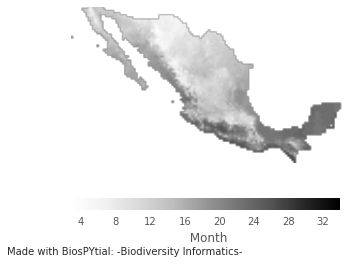

In [72]:
elevation.display_field(origin='Lower')

In [73]:
predicted_data = predictions.mean_sample.values

### Using the Raster Container

In [74]:
presences_of_something = RasterContainer(predicted_data,use_metadata_from=elevation.rasterdata)

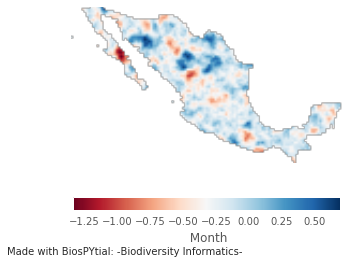

In [77]:
presences_of_something.display_field(band=1,origin='Lower',cmap=plt.cm.RdBu)

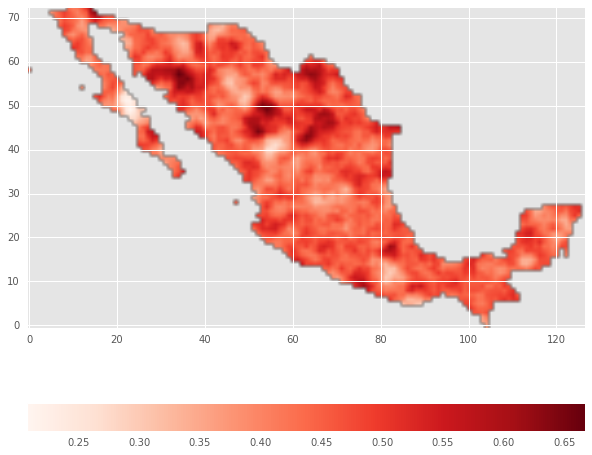

In [79]:
from scipy.special import expit
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(expit(presences_of_something.rasterdata.bands[0].data()),origin='Lower',cmap=plt.cm.Reds)
plt.colorbar(orientation='horizontal')